In [1]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common import make_vec_env
from stable_baselines import A2C
from stable_baselines.common.env_checker import check_env
from IPython.display import clear_output
import time
from copy import deepcopy
from ray import tune
from stable_baselines.common.callbacks import BaseCallback

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



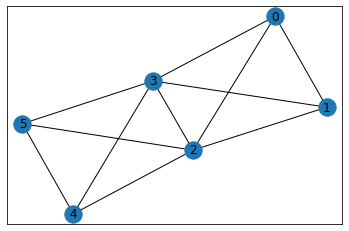

In [2]:
import gym
import w_mac
from collections import defaultdict
import matplotlib as plt
import networkx as nx

d = defaultdict(list)
"""Larger network"""
#data = [(0,2),(0,1),(0,3),(1,2),(1,3),(2,3),(2,4),(3,4),(5,2),(5,3),(5,4),(5,6),(6,7),(6,8),(7,8),(8,9),(9,10),(4,10)]#(4,6),(5,10),(6,10),(9,6),(8,10)]
"""Smaller netowrk"""
data = [(0,2),(0,1),(0,3),(1,2),(1,3),(2,3),(2,4),(3,4),(5,2),(5,3),(5,4)]
# defaultdict(<type 'list'>, {})
for node, dest in data:
    d[node].append(dest)

G = nx.Graph()
for k,v in d.items():
    for vv in v:
        G.add_edge(k,vv)
nx.draw_networkx(G)

In [3]:
env = gym.make('wmac-graph-v0',graph=G)

In [4]:
check_env(env)

node 0 waiting to send
Action taken on empty queue
node 2 waiting to send


AttributeError: 'W_MAC_Env' object has no attribute 'routing_table'

In [ ]:
import tensorflow as tf

class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """
    def __init__(self, verbose=0):
        self.is_tb_set = False
        super(TensorboardCallback, self).__init__(verbose)

    def _on_step(self) -> bool:
        # Log additional tensor
        if not self.is_tb_set:
            with self.model.graph.as_default():
                tf.summary.scalar('packet_lost', tf.reduce_mean(env.get_packet_lost()))
                self.model.summary = tf.compat.v1.summary.merge_all()
            self.is_tb_set = True
        # Log scalar value (here a random variable)
        value = env.get_packet_lost()
        summary = tf.Summary(value=[tf.Summary.Value(tag='packet_lost', simple_value=value)])
        self.locals['writer'].add_summary(summary, self.num_timesteps)
        return True

In [ ]:
#model = A2C(MlpPolicy, env, verbose=1,tensorboard_log="./a2c_tensorboard/")
#model.learn(total_timesteps=600000, callback=TensorboardCallback())
#model.save("a2c_wmac")

In [ ]:

### Train with hyperparameter tuning. 

model = A2C(MlpPolicy, 
            env, 
            verbose=1,
            gamma = 0.9902283585257828,
            max_grad_norm = 3.1478082166984676,
            learning_rate=0.0006449103234149516,
            tensorboard_log="./a2c_tensorboard_tuned_small/")

model.learn(total_timesteps=400000,
            callback=TensorboardCallback())
model.save("a2c_wmac_small_tuned")


In [ ]:
del model # remove to demonstrate saving and loading

In [ ]:
"""Code to test the trained model"""

model = A2C.load("a2c_wmac_small_tuned")

obs = env.reset()
count = 0
while count < 5000:
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()
    count = count + 1
    time.sleep(3)
    clear_output(wait = True)
    if done:
        env.render()
        break
